In [1]:
import os
import sys

sys.path.insert(0, "../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ARDL, VAR
from statsmodels.tsa.ardl import ardl_select_order
from sklearn.decomposition import PCA
from src.text.epu import EPU
from src.text.gui import DrawTopics
from src.tourism.ts_utils import get_adf_df
from src.google_trends import GT
from dotenv import load_dotenv

load_dotenv()

True

## EPU

In [2]:
data_dir = sys.path[0] + "/data/text/solomon_islands/"
target_dir = sys.path[0] + "/outputs/text/solomon_islands/"

data_files = [
    data_dir + file for file in os.listdir(data_dir) if "news" in file
    and "ner" not in file
]

ner_files = [
    data_dir + file for file in os.listdir(data_dir) if "ner" in file
]

In [3]:
urls_to_exclude = []
for file in ner_files:
    df = pd.read_csv(file)
    df["ner"] = df["ner"].str.lower()
    urls = [
        url for ner, url in zip(df["ner"], df["url"])
        if "risk" in str(ner) or "uncertain" in str(ner)
    ]
    urls_to_exclude.extend(urls)

In [4]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.1,
    104.0, 104.3, 104.4, 104.9, 104.1, 105.7, 104.8, 105.0, 105.1, 105.7,
    105.9, 106.3, 107.0, 107.5, 107.5, 114.2, 114.3, 114.1, 113.4, 112.2,
    107.6, 106.1, 105.3, 105.7, 105.6, 106.0, 104.5, 107.8, 111.6, 113.8,
    111.1, 110.8, 107.6, 106.9, 107.3, 108.0, 108.1, 108.2, 108.7, 109.8,
    110.4, 110.5, 112.7, 114.1, 114.3, 115.6, 117.6, 118.5, 119.8, 119.3,
    118.6, 120.3, 120.1, 120.0, 119.9, 119.6, 119.8, 120.9, 120.7, 120.9
]

si_cpi_df = pd.DataFrame(pd.date_range("2017-01", "2023-09", freq="MS"),
                         columns=["date"])
si_cpi_df["cpi"] = si_cpi

In [5]:
e = EPU(data_files, cutoff="2019-12-31", non_epu_urls=urls_to_exclude)
e.get_epu_category("date >= '2015-01-01' and date < '2024-01-01'")
e.get_count_stats()
e.calculate_epu_score()
epu = e.epu_stats

## GUI

In [70]:
inflation_prompts = [
    "inflation", "CPI", "food price", "purchasing power"
]
GoogleAPIkey = os.getenv("GoogleAPIkey")
gt = GT(GoogleAPIkey)

dnx = DrawTopics(inflation_prompts, "SB", gt)
dnx.trends_to_nx_object()
words_df = dnx.result
inflation_words = words_df[words_df.volume >= 5]["target"].unique().tolist()

In [71]:
local_trends = pd.DataFrame()
for word in inflation_words:
    r = gt.get_graph(word, "SB", "2016-01")
    r_df = gt.to_df(r)
    r_df = (r_df.drop("term", axis=1).rename({"value": word.replace(" ", "_")}, axis=1))
    if local_trends.empty:
        local_trends = r_df
    else:
        local_trends = local_trends.merge(r_df, how="left", on="date")

In [72]:
cols = local_trends.columns[~local_trends.columns.isin(["date"])]
local_trends["trends"] = local_trends[cols].sum(axis=1)

## Sentiment

In [9]:
ep_sentiment = (pd.read_csv(target_dir + "sentiment/solomon_islands_sentiment.csv")
                  .drop("Unnamed: 0", axis=1))
si_cpi_df = si_cpi_df.merge(epu[["date", "epu_weighted"]], how="left", on="date")
ep_sentiment["date"] = pd.to_datetime(ep_sentiment["date"])
si_cpi_df = si_cpi_df.merge(ep_sentiment, how="left")
si_cpi_df = si_cpi_df.merge(local_trends[["date", "trends"]], how="left")

In [10]:
si_cpi_df["inflation"] = si_cpi_df["cpi"].diff().div(si_cpi_df["cpi"].shift(1)) * 100
si_cpi_df["score_diff"] = si_cpi_df["score"].diff()
si_cpi_df["epu_ma3"] = si_cpi_df["epu_weighted"].rolling(3).mean()

model_df = si_cpi_df.dropna().reset_index(drop=True)

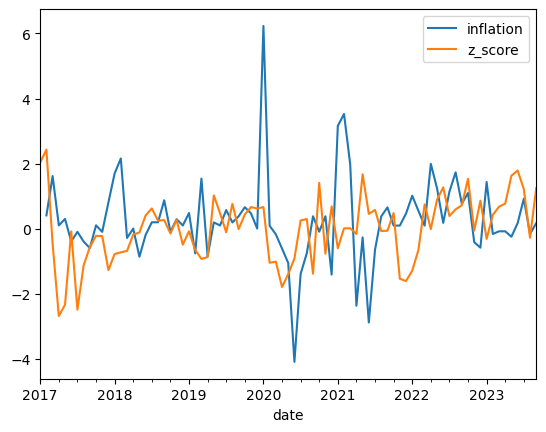

In [11]:
si_cpi_df.plot(x="date", y=["inflation", "z_score"]);

## Modeling
### Stationarity

In [12]:
get_adf_df(model_df, [
    'cpi', 'epu_weighted', "epu_ma3", 'score', 'z_score', 'inflation',
    'score_diff', "trends"
])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
cpi,-0.861483,8.003919e-01,1.0,77.0,-3.518281,-2.899878,-2.587223
epu_weighted,-3.614446,5.490778e-03,4.0,74.0,-3.521980,-2.901470,-2.588072
epu_ma3,-2.275811,1.798883e-01,7.0,71.0,-3.526005,-2.903200,-2.588995
score,-3.637184,5.088666e-03,1.0,77.0,-3.518281,-2.899878,-2.587223
z_score,-3.637184,5.088666e-03,1.0,77.0,-3.518281,-2.899878,-2.587223
inflation,-7.064806,5.113190e-10,0.0,78.0,-3.517114,-2.899375,-2.586955
score_diff,-5.968593,1.960666e-07,5.0,73.0,-3.523284,-2.902031,-2.588371
trends,-6.350815,2.613707e-08,0.0,78.0,-3.517114,-2.899375,-2.586955


### PCA

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_df[["epu_weighted_std", "trends_std"]] = scaler.fit_transform(model_df[["epu_weighted", "trends"]])

In [65]:
pca = PCA(n_components=1)
model_df["pc"] = pca.fit_transform(model_df[["epu_weighted_std", "trends_std"]])
print(pca.explained_variance_ratio_)

[0.67080898]


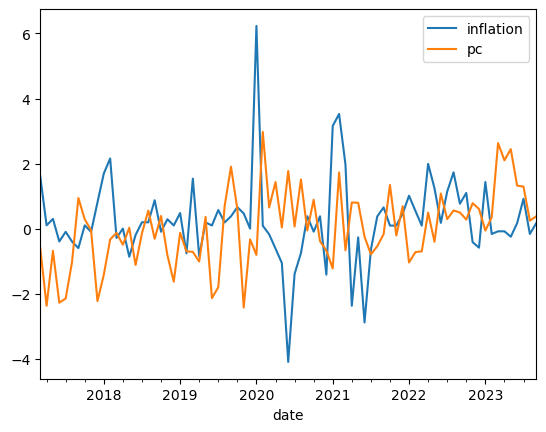

In [66]:
model_df.plot(x="date", y=["inflation", "pc"]);

## VAR(MA)

In [96]:
length = len(model_df)
train = int(length * 0.95)
test = length - train

model = VAR(endog=model_df.loc[:train + 1, ["inflation", "pc"]])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i, trend="c")
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)

eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,0.774024,0.958030,2.168654,0.847562
1,2,0.718589,1.027588,2.052350,0.841969
2,3,0.796619,1.232523,2.220548,0.970507
3,4,0.736886,1.301656,2.094694,0.961957
4,5,0.732895,1.428543,2.091157,1.009834
5,6,0.783461,1.612048,2.207397,1.112963
6,7,0.769685,1.733326,2.188417,1.152455
7,8,0.856054,1.956918,2.403086,1.292803
8,9,0.804997,2.045310,2.306027,1.296447
9,10,0.943936,2.325982,2.684770,1.490815


In [97]:
res = model.fit(ic="aic", trend="c")
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Feb, 2024
Time:                     17:48:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.02759
Nobs:                     75.0000    HQIC:                  0.841969
Log likelihood:          -229.788    FPE:                    2.05235
AIC:                     0.718589    Det(Omega_mle):         1.80382
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.192869         0.151698            1.271           0.204
L1.inflation         0.191256         0.116793            1.638           0.102
L1.pc                0.024560         0.138245            0.

In [103]:
print(res.test_causality("inflation", ["pc"]).summary())
print(res.test_inst_causality("pc").summary())
print(res.test_whiteness().summary())

Granger causality F-test. H_0: pc does not Granger-cause inflation. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.192          3.061   0.044 (2, 140)
----------------------------------------------
Instantaneous causality Wald-test. H_0: pc does not instantaneously cause inflation. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1.521          3.841   0.217  1
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         42.49          46.19   0.102 32
----------------------------------------


In [83]:
forecast = res.forecast(y=model_df.loc[train:,
                                       ["inflation", "pc", "z_score"]].values,
                        steps=test)[:, 0]

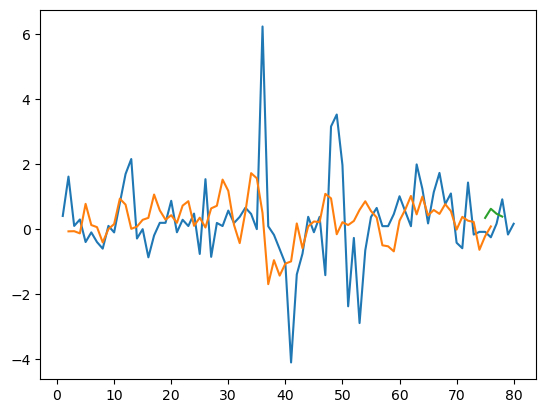

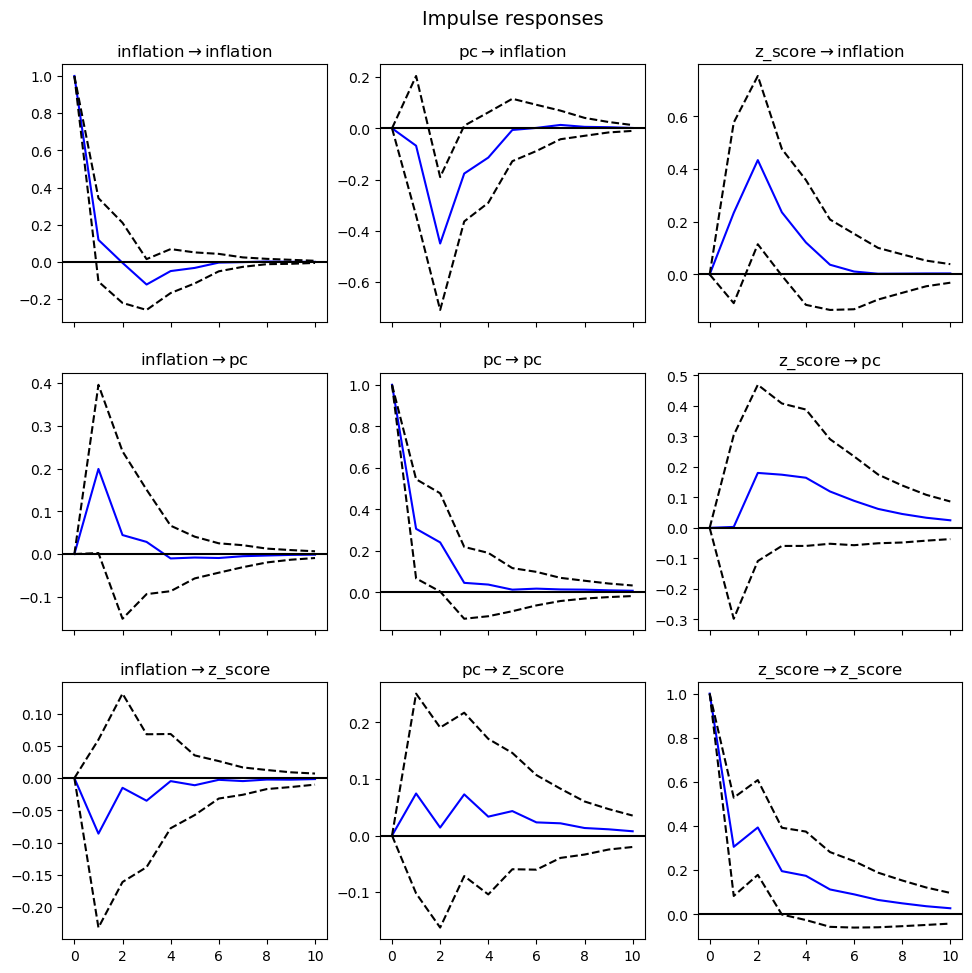

In [84]:
import matplotlib.pyplot as plt
plt.plot(si_cpi_df["inflation"].values)
plt.plot(res.fittedvalues["inflation"]);
plt.plot(model_df.index[-test:], forecast)
res.irf().plot();